# CIFAR-10 DC-GAN

- CIFAR-10을 통해서 DC-GAN 모델 익히기

## 1. 데이터 준비

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline

tf.random.set_seed(1234)
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

print("tensorflow", tf.__version__)

tensorflow 2.4.1


label은 필요하지 않으므로 _로 받아온다.

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (_, _) = cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


32x32 image data

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [5]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [6]:
train_x.shape

(50000, 32, 32, 3)

image - channel 고려해주기

In [7]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

데이터 확인하기

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


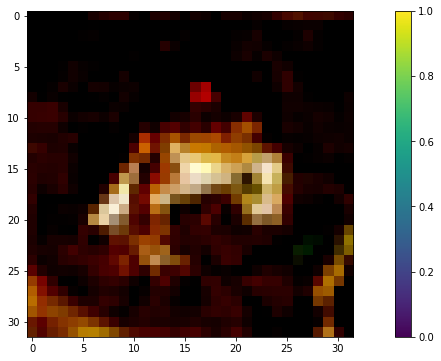

In [8]:
plt.imshow(train_x[0])
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

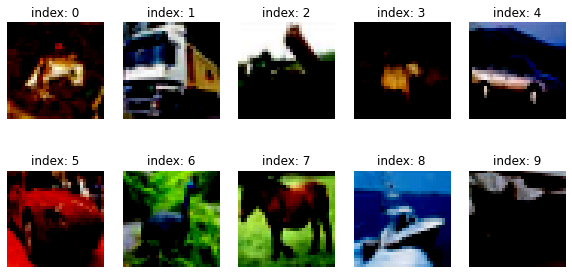

In [9]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

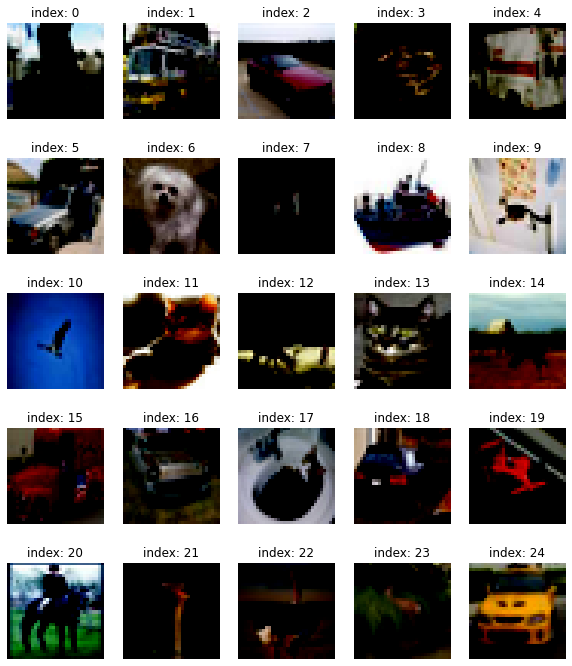

In [10]:
plt.figure(figsize=(10, 12))

for i in range(25):
    rand = np.random.randint(0,49999)
    plt.subplot(5, 5, i+1)
    plt.imshow(train_x[rand])
    plt.title(f'index: {i}')
    plt.axis('off')

plt.show()

훈련에 사용하기 위해서 dataset에 담아두자.

In [11]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128

In [72]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_x라는 nd.array형 자료를 섞고 이를 배치 사이즈에 따라 나누자

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 2. 모델 구성하기

### Generator

Conv2D-Transpose : 이미지를 줄이는 것이 아니고 이미지를 점차 늘려간다.

(8,8,256) ->(8,8,128) -> (16,16,64) -> (32,32,3)

In [71]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    # Second: Reshape layer
    #Conv2d 레이어에 넣기 위해서 reshape
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    #tanh = 출력 분포를 -1 ~ 1로 돌리기 위해서
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [20]:
generator = make_generator_model()

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_4 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)        

임의 노이즈 입력해서 결과 확인

In [13]:
noise = tf.random.normal([1, 100])

TF 2.0 이후 버전에선 레이어와 모델에 call 메소드를 구현해 놓기 때문에 방금 생성한 모델에 넣으면 결과가 생성

In [22]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

학습을 하지 않았지만 (32,32,3)의 이미지는 얻을 수 있었다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


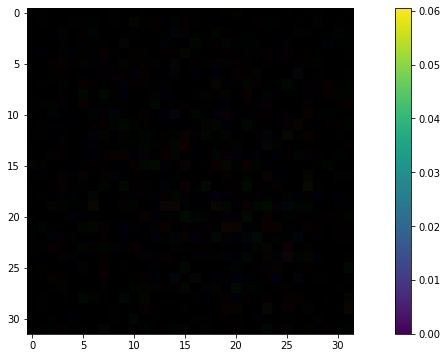

In [23]:
plt.imshow(generated_image[0, :, :, :])
plt.colorbar()
plt.show()

___

### Discriminator

이미지를 다시 분해하면서 특성 확인

(32, 32, 3) → (16, 16, 64) -→ (8, 8, 128)

In [24]:
def make_discriminator_model():

    # Start
    #(32,32,3)
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    #(16,16,64)
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    #(8,8,128)
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    # 정규화되지 않은 출력
    model.add(layers.Dense(1)) 

    return model

In [25]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

아직 아무 의미 없어보인다.

In [26]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00423186]], dtype=float32)>

___

### 손실 함수

GAN은 손실함수로 Cross Entropy - discriminator는 이미지가 진짜/가짜인지 구분하므로 binary-cross entropy를 사용

**D(fake_image), D(real_image)**를 손실 함수의 입력으로 사용

### Generator_loss

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator : D(fake_image)가 1에 가까워져야 하므로 tf.ones_like와의 교차 엔트로피값을 계산

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Discriminator_loss

discriminator : D(fake_image)는 0에, D(real_iamge)는 1에 가까워져야 한다. 따라서 각각 tf.zeros_like, tf.ones_like와 비교

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

discriminator가 real/fake를 얼마나 정확히 판별하는 지도 중요

이때 accuracy가 1에 가까우면 좋지 않다. 왜 why? real/fake 간의 차이가 크다는 것. accuracy가 0.5에 가까워야 이상적

tf.math.greater_equal(0.5) : 각 원소가 0.5이상인지 True/False   
tf.cast(float32) : float32로 원소 변환. Boolean이면 float으로.

In [17]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

___

### Optimzer

generator/discriminator는 따로 따로 학습을 하기 때문에 optimzer도 각각 설정해준다.

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

16개의 샘플로 개선 상황 확인

In [19]:
noise_dim = 100
num_examples_to_generate = 16
tf.random.set_seed(1234)

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

___

## 3. 모델 훈련하기

tf에서 사용할 수 있는 **graph type**으로 변경됐다.

### 훈련 기능 구현

In [57]:
@tf.function
def train_step(images):  #(1) 입력데이터(real image 역할)
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈 : fake_image 생성에 활용

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈 :Gradient 갱신을 위해서
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    #optimzer에 계산된 gradient 입력해서
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

주기적으로 샘플 저장해서 훈련 과정 확인

In [53]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')
    
    try :
        plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'\
                    .format(os.getenv('HOME'), epoch, it))
    except OSError:
        os.makedirs(os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/generated_samples')       
    
    plt.show()

#### 학습 과정 시각화

In [54]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

훈련 과정 저장할 checkpoint

In [55]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Train

In [56]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [37]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

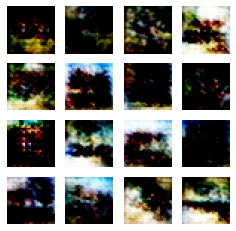

Time for training : 1461 sec


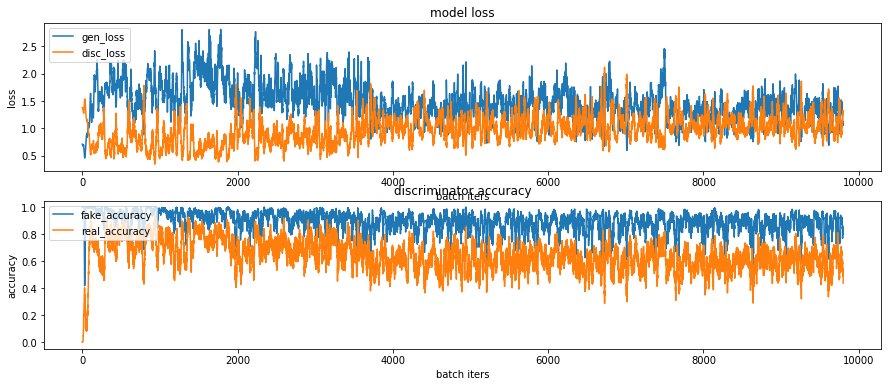

CPU times: user 25min 32s, sys: 52.7 s, total: 26min 25s
Wall time: 24min 22s


In [33]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

학습 과정 GIF로 만들기

In [34]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1325766 Aug 26 13:37 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


![cifar10_mnist_dcgan](https://user-images.githubusercontent.com/86637320/131223380-7af277d1-debd-4083-af8f-f19317db73f0.gif)


#### 문제점 

1. 이미지 생성이 제대로 되지 않았다.

2. 제대로 이미지가 생성되지 않았기 때문에 fake accuracy가 매우 높게 나왔다.

우선은 이미지부터 제대로 생성해보자.

___

## 4. 모델 개선하기

#### 1. 네트워크 구조 변경해보기

#### G : (2,2,512) -> (4,4,256) -> (8,8,128) -> (16,16,64) -> (32,32,3)

#### D : (32,32,3) -> (16,16,64) -> (8,8,128) -> (4,4,256) -> (2,2,512) -> 2048 -> 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

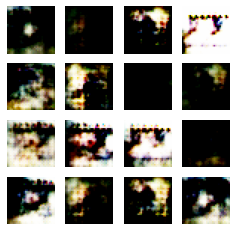

Time for training : 4125 sec


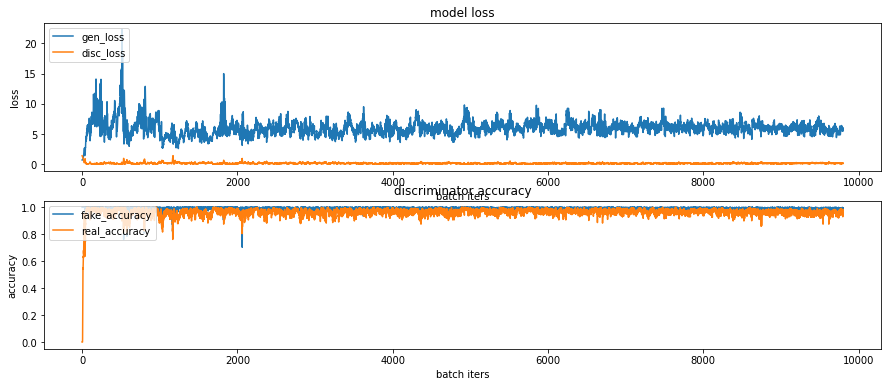

CPU times: user 1h 8min 20s, sys: 21.1 s, total: 1h 8min 41s
Wall time: 1h 8min 46s


In [65]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

![model1_cifar10_mnist_dcgan](https://user-images.githubusercontent.com/86637320/131673206-9531e035-3a09-40c4-9742-b5c15e6377ab.gif)

___

#### 2. 배치 사이즈 변경

- BATCH_SIZE : 128

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

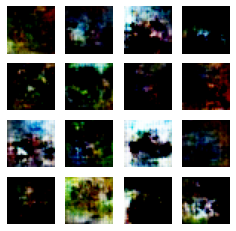

Time for training : 1228 sec


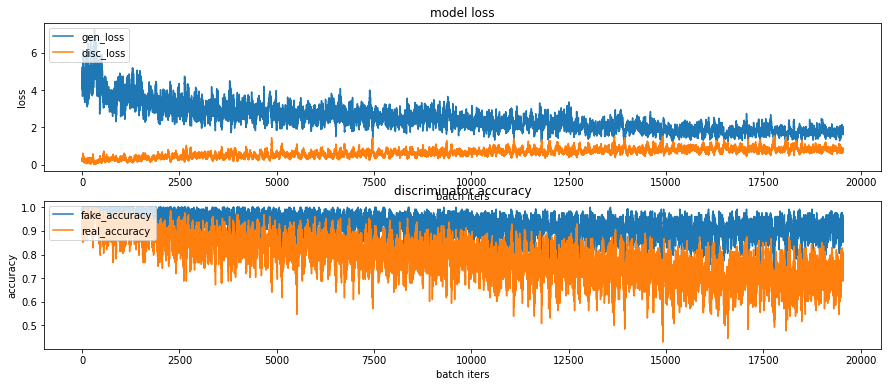

CPU times: user 9min 32s, sys: 42.7 s, total: 10min 14s
Wall time: 20min 30s


In [97]:
%%time
train(train_dataset, EPOCHS, save_every)

![model2_cifar10_mnist_dcgan](https://user-images.githubusercontent.com/86637320/131248393-026d41a4-fb69-4b97-8602-4fdacf3a7ae9.gif)

#### 100 EPOCHES 실행 : 결과가 좋지 않다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

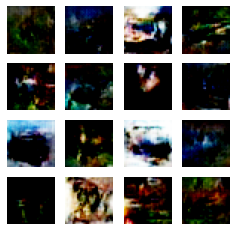

Time for training : 1233 sec


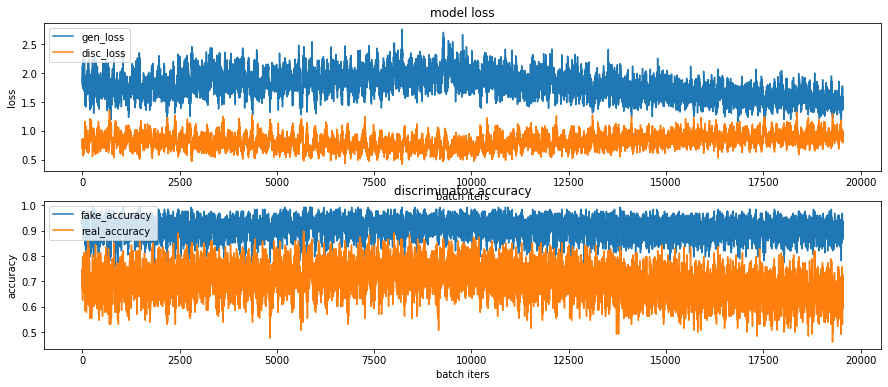

CPU times: user 9min 37s, sys: 42.5 s, total: 10min 20s
Wall time: 20min 34s


In [100]:
%%time
train(train_dataset, EPOCHS, save_every)

![model3_cifar10_mnist_dcgan](https://user-images.githubusercontent.com/86637320/131248404-844fdac7-9915-4188-bdba-383457d0aa28.gif)


___

#### 3. Discriminator 변경
- Discriminator의 마지막 dense layer의 activation function을 sigmoid로 설정

fake accuracy가 0.5를 향해 줄어드는 양상 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

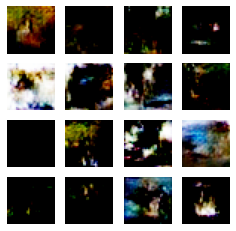

Time for training : 2666 sec


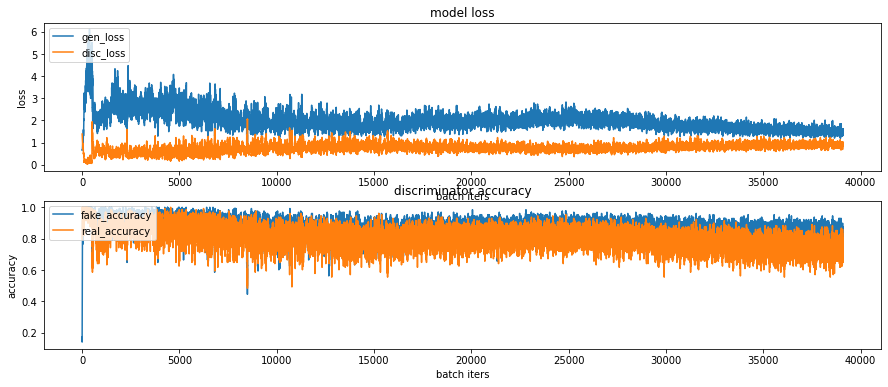

CPU times: user 24min 55s, sys: 1min 55s, total: 26min 51s
Wall time: 44min 28s


In [28]:
%%time
train(train_dataset, EPOCHS, save_every)

![model3_cifar10_mnist_dcgan (2)](https://user-images.githubusercontent.com/86637320/131672447-db28c494-7455-4c3d-be55-a53ef23aec5d.gif)


___

#### 4. 모델 3의 하이퍼 파라미터 변경

#### Discriminator_loss 수정

- real image의 label을 0.9로 변경 : Label Smoothing

#### Discriminator_LR 수정

- discriminator의 LR을 더 낮게 설정

#### EPOCH = 1000

7번째에 강아지로 추정되는 이미지가 생성됐다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

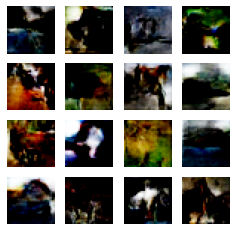

Time for training : 31268 sec


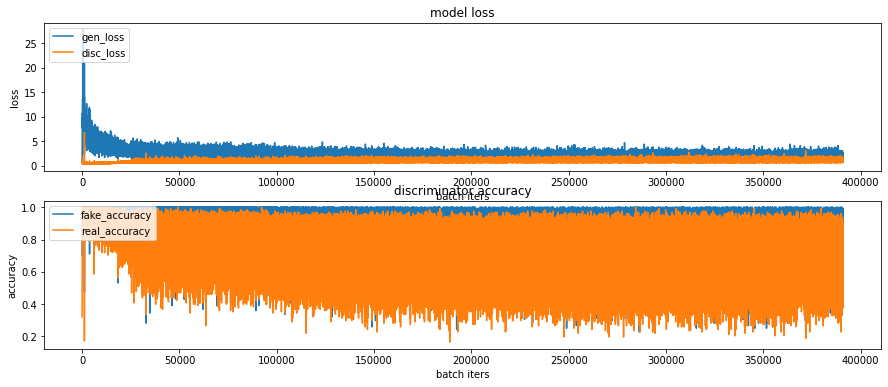

CPU times: user 5h 26min 42s, sys: 18min 5s, total: 5h 44min 48s
Wall time: 8h 41min 24s


In [37]:
%%time
train(train_dataset, EPOCHS, save_every)

___

![model4_cifar10_mnist_dcgan](https://user-images.githubusercontent.com/86637320/131769964-9d5e2c13-3ea8-41c7-a24f-21ad33581c0f.gif)


# 정리

DCGAN을 CIFAR10 이미지에 적용해보았다. FASHION MNIST의 경우 간단한 모델을 이용하면서 적은 에포크를 가지고도
충분히 좋은 이미지를 만들어낼 수 있었지만 CIFAR 10 이미지의 경우 알아볼 수 있는 이미지를 만들기까지 많은 수행 착오를 겪었다. 이미지 결과를 개선하기 위해서 해본 시도는 다음과 같다.

1. G/D 모델 구조 변경하기

2. BATCCH SIZE 변경하고 에프크 증가시키기

3. D 모델 출력 부분 Activation function 변경하기

4. D Label smoothing, D LR을 G의 LR 보다 낮게 만들기